# GTSRB - Simple Model

In [2]:
% matplotlib notebook

from src.data import BatchServer, utils

import math

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

dataset_train = "../data/gtsrb-train.tfrecords"
dataset_test = "../data/gtsrb-test.tfrecords"

learning_rate = 0.001
batch_size = 128
epochs = 40

# Create input and output placeholders
X = tf.placeholder(tf.float32, [None, 4800], "X")
Y = tf.placeholder(tf.float32, [None, 43], "Y")

# Initialize weights
# Hidden layer 
w_h = tf.Variable(tf.random_normal([4800, 400], stddev=0.01)) 
# Output layer
w_o = tf.Variable(tf.random_normal([400, 43], stddev=0.01))

# Define model
with tf.name_scope("hidden"):
    hidden = tf.nn.sigmoid(tf.matmul(X, w_h))
with tf.name_scope("output"):
    p_y = tf.nn.softmax(tf.matmul(hidden, w_o))

# Define cost function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=p_y, labels=Y))
# Define train operation
train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# Add summary to cost tensor
tf.summary.scalar("cost", cost)

# Accuracy function
# Count correct predictions
correct_pred = tf.equal(tf.argmax(p_y, 1), tf.argmax(Y, 1))
# Calculate average accuracy
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
tf.summary.scalar("accuracy", accuracy)

# Calculate number of records in dataset
num_train_records = utils.get_number_of_records(dataset_train)
num_test_records = utils.get_number_of_records(dataset_test)

# Read input data
train_data = BatchServer(dataset_train, 40 * 40 * 3, 43, tf.uint8, batch_size)
test_data = BatchServer(dataset_test, 40 * 40 * 3, 43, tf.uint8, num_test_records)

print("Train Set: {} Examples".format(num_train_records))
print("Test Set: {} Examples".format(num_test_records))

with tf.Session() as sess:

    # Initialize variables
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    
    # Create training coordinator
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    print("Training...")
    
    # Store train accuracies in array
    accuracies_train = {}
    # Store test accuracies in dict
    accuracies_test = {}
    
    for i in range(epochs):
               
        iterations_per_epoch = math.floor(num_train_records / batch_size)
    
        for j in range(iterations_per_epoch):
            # Get next batch of images and labels
            train_batch_images, train_batch_labels = sess.run(train_data.next_batch())
            
            # Run training
            sess.run(train, feed_dict={X: train_batch_images, Y: train_batch_labels})

            # Calculate accuracy
            train_accuracy = sess.run(accuracy, feed_dict={X: train_batch_images, Y: train_batch_labels})
            
            accuracies_train[i * iterations_per_epoch + j] = train_accuracy
            
            # Calculate test accuracy 10 times per epoch
            if j % int(iterations_per_epoch * 0.5) == 0:
                
                # Calculate test accuracy once per epoch
                test_batch_images, test_batch_labels = sess.run(test_data.next_batch())
                test_accuracy = sess.run(accuracy, feed_dict={X: test_batch_images, Y: test_batch_labels})
                
                accuracies_test[i * iterations_per_epoch + j] = test_accuracy
                
                print('Epoch: {:02d} \t Batch: {:02d} \t Train Accuracy {:02f} \t Test Accuracy: {:02f}'.format(i, j, train_accuracy, test_accuracy))
                                
    # Stop coordinator
    coord.request_stop()
    coord.join(threads)

Train Set: 16866 Examples
Test Set: 2912 Examples
Training...
Epoch: 00 	 Batch: 00 	 Train Accuracy 0.000000 	 Test Accuracy: 0.012706
Epoch: 00 	 Batch: 65 	 Train Accuracy 0.039062 	 Test Accuracy: 0.019918
Epoch: 00 	 Batch: 130 	 Train Accuracy 0.023438 	 Test Accuracy: 0.021635
Epoch: 01 	 Batch: 00 	 Train Accuracy 0.054688 	 Test Accuracy: 0.026099
Epoch: 01 	 Batch: 65 	 Train Accuracy 0.015625 	 Test Accuracy: 0.023008
Epoch: 01 	 Batch: 130 	 Train Accuracy 0.015625 	 Test Accuracy: 0.026442
Epoch: 02 	 Batch: 00 	 Train Accuracy 0.031250 	 Test Accuracy: 0.024725
Epoch: 02 	 Batch: 65 	 Train Accuracy 0.023438 	 Test Accuracy: 0.034684
Epoch: 02 	 Batch: 130 	 Train Accuracy 0.007812 	 Test Accuracy: 0.030220
Epoch: 03 	 Batch: 00 	 Train Accuracy 0.023438 	 Test Accuracy: 0.031593
Epoch: 03 	 Batch: 65 	 Train Accuracy 0.031250 	 Test Accuracy: 0.039492
Epoch: 03 	 Batch: 130 	 Train Accuracy 0.039062 	 Test Accuracy: 0.036401
Epoch: 04 	 Batch: 00 	 Train Accuracy 0.05468

Epoch: 36 	 Batch: 130 	 Train Accuracy 0.132812 	 Test Accuracy: 0.121909
Epoch: 37 	 Batch: 00 	 Train Accuracy 0.125000 	 Test Accuracy: 0.112637
Epoch: 37 	 Batch: 65 	 Train Accuracy 0.132812 	 Test Accuracy: 0.122940
Epoch: 37 	 Batch: 130 	 Train Accuracy 0.148438 	 Test Accuracy: 0.119505
Epoch: 38 	 Batch: 00 	 Train Accuracy 0.101562 	 Test Accuracy: 0.128777
Epoch: 38 	 Batch: 65 	 Train Accuracy 0.125000 	 Test Accuracy: 0.121223
Epoch: 38 	 Batch: 130 	 Train Accuracy 0.101562 	 Test Accuracy: 0.129464
Epoch: 39 	 Batch: 00 	 Train Accuracy 0.101562 	 Test Accuracy: 0.125000
Epoch: 39 	 Batch: 65 	 Train Accuracy 0.093750 	 Test Accuracy: 0.116415
Epoch: 39 	 Batch: 130 	 Train Accuracy 0.140625 	 Test Accuracy: 0.118132


<IPython.core.display.Javascript object>


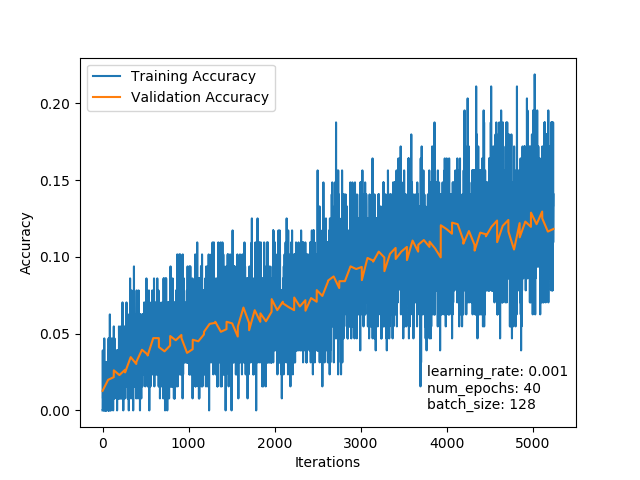

In [10]:
# Plot 
plt.plot(*zip(*sorted(accuracies_train.items())), label="Training Accuracy")
plt.plot(*zip(*sorted(accuracies_test.items())), label="Validation Accuracy")

plt.xlabel("Iterations")
plt.ylabel("Accuracy")

plt.text(0.72 * len(accuracies_train),0.001, "learning_rate: {} \nnum_epochs: {} \nbatch_size: {}".format(learning_rate, epochs, batch_size))

plt.legend()